## Variable selection 8: conditional statistics

This notebook goes with the blog post: Variable selection in Python, part II.

### Preliminaries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, make_scorer
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.linear_model import LinearRegression

### Data loading

In [2]:
data = pd.read_csv('../data/Table2_Hunt_2013_edit.csv')

In [3]:
data = data.loc[:, ['Production', 'Position', 'Gross pay', 'Phi-h', 'Pressure', 'Random 1', 'Random 2', 'Gross pay transform']]
data.head()

,Production,Position,Gross pay,Phi-h,Pressure,Random 1,Random 2,Gross pay transform
0,15.10,2.1,0.1,0.5,19,5,379,3.54
1,21.30,1.1,1.0,4.0,16,13,269,5.79
2,22.75,1.0,1.9,19.0,14,12,245,8.51
3,15.72,2.1,3.1,21.7,17,6,273,11.52
4,7.71,2.9,4.1,24.6,11,10,237,10.16


### Color heatmap by production 

Can we learn something by splitting the data into different classes, using Production cutoffs as categorical variable?

In [4]:
col         = 'Production'
conditions  = [ data[col] >= 50, (data[col] < 50) & (data[col]> 20), data[col] <= 20]
choices     = [ 'high', 'medium', 'low' ]

# https://stackoverflow.com/a/39111919/1034648
data['Production_classes'] = np.select(conditions, choices, default=np.nan) 

To answer that question let's first take a look again at the scatter matrix, when all bivariate scatterplots are colored by production classes.

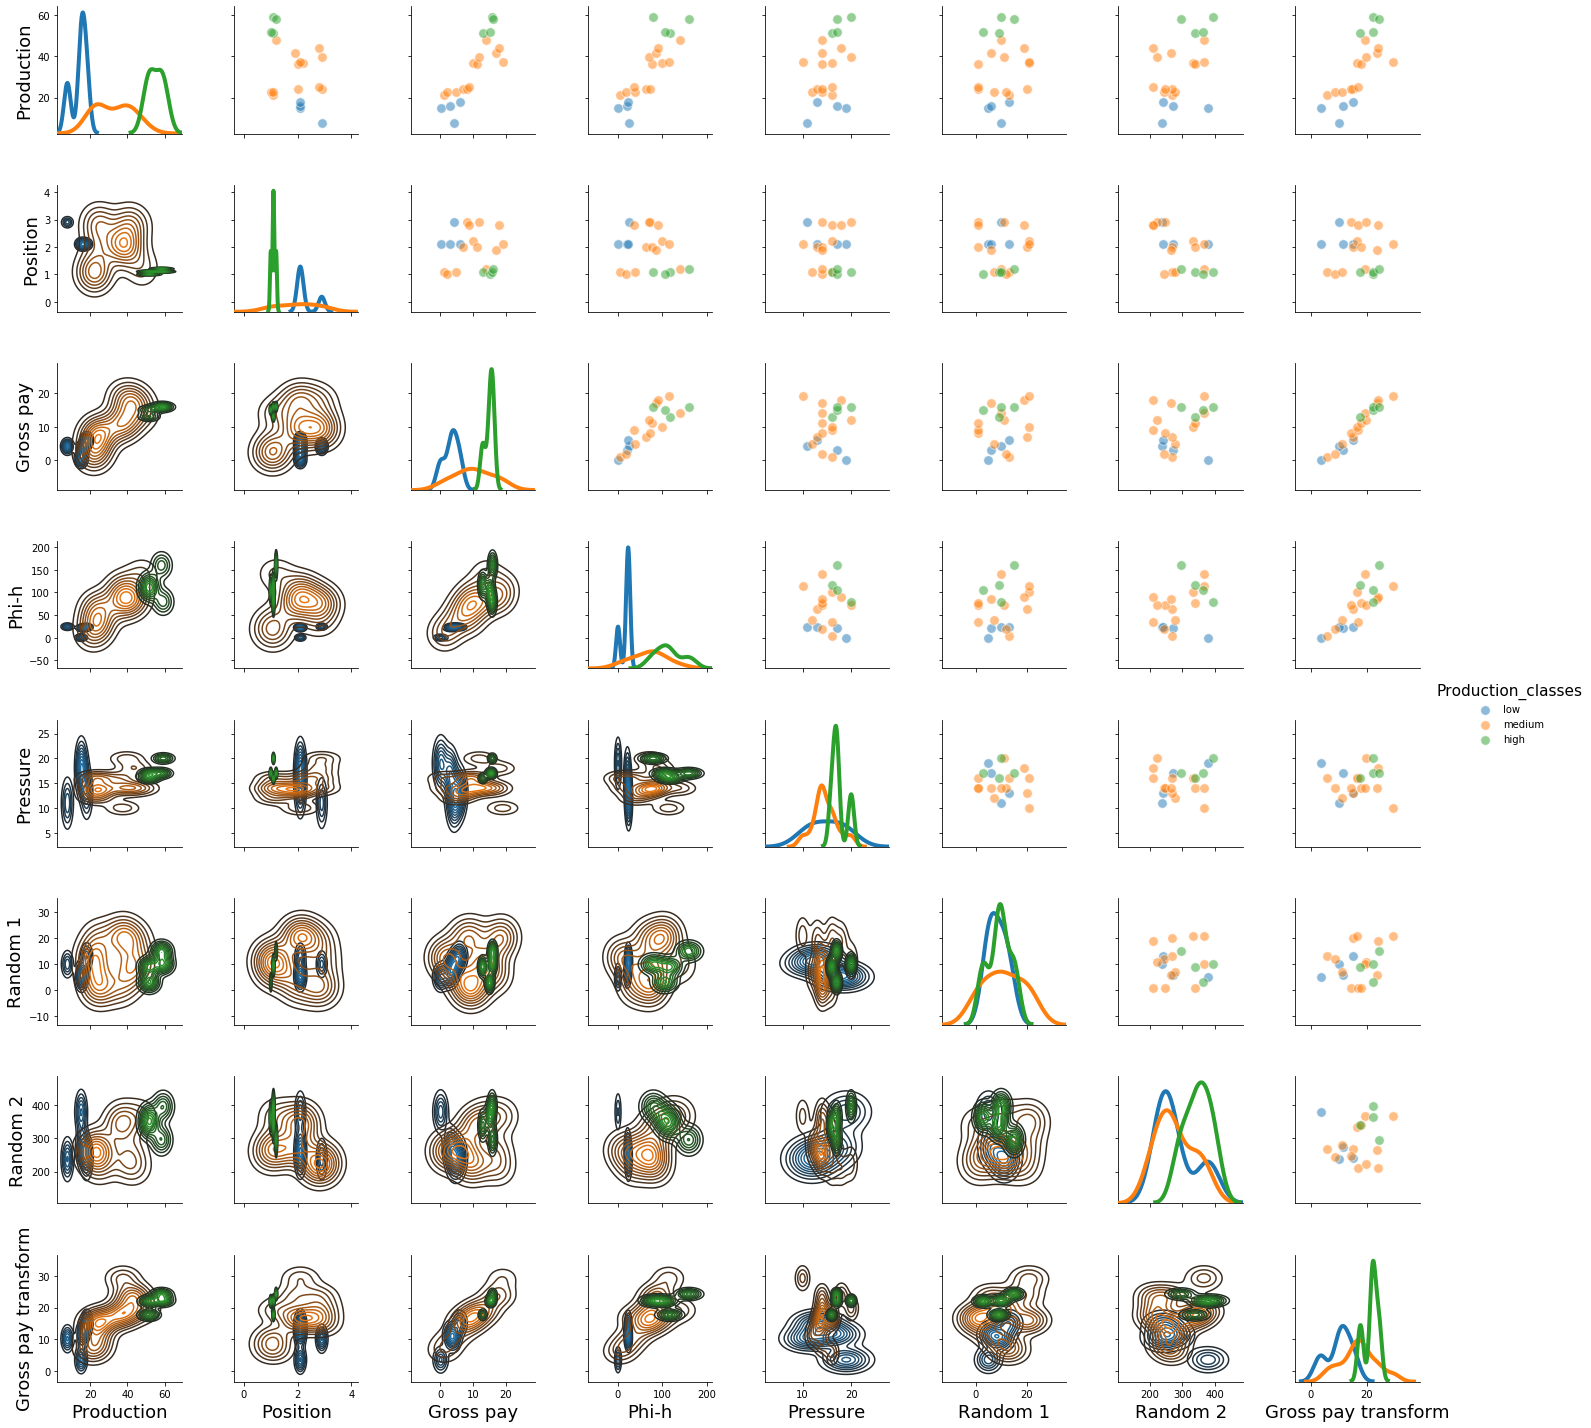

In [5]:
plt.rcParams["axes.labelsize"] = 18
g = sns.PairGrid(data, diag_sharey=False, hue='Production_classes')
g.map_upper(plt.scatter,  linewidths=1, edgecolor="w", s=90, alpha = 0.5)
g = g.add_legend()
g.map_diag(sns.kdeplot, lw = 4, legend=False)
g.map_lower(sns.kdeplot)

plt.show()

Looking at the first row, and also at the KDEs in the diagonal, it certainly does look like production classes cluster separately.

### Conditional statistics

The idea for the box plot using conditional statistics is taken from [Feature Selection for Subsurface Data Analytics](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Feature_Ranking.ipynb) by [Michael Pyrcz](https://github.com/GeostatsGuy).

Having split each well into low, medium and high production allows access to the difference in the conditional statistics. This provides a more flexible method to compare the relationship between each feature and production: if the conditional statistics change significantly then that feature is informative.

In [6]:
x = data[['Position','Gross pay','Phi-h','Pressure','Random 1','Random 2','Gross pay transform']]
x_stand = (x - x.mean()) / (x.std())      # standardization by feature
x = pd.concat([data['Production_classes'],x_stand.iloc[:,0:6]],axis=1) # add the production categorical feature to the DataFrame
x = pd.melt(x,id_vars="Production_classes",var_name="Predictor Feature",value_name='Standardized Predictor Feature')

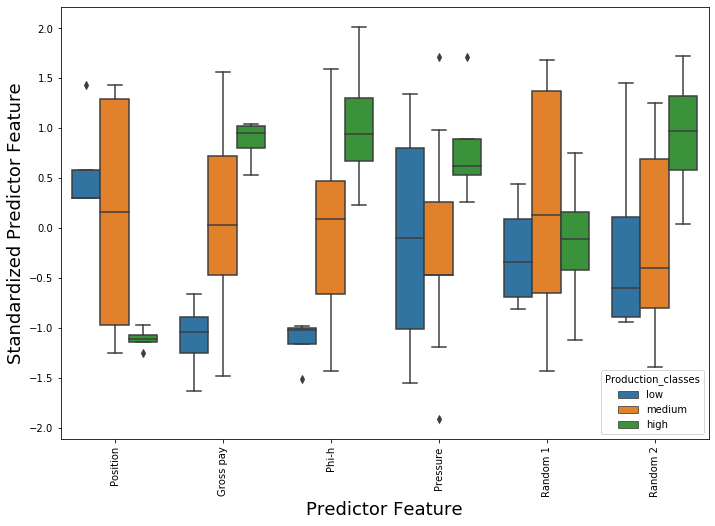

In [7]:
plt.subplot(111)
sns.boxplot(x='Predictor Feature', y='Standardized Predictor Feature', hue='Production_classes', data=x)
plt.xticks(rotation=90)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.2)
plt.legend(title='Production_classes',loc='lower right')
plt.show()
